In [211]:
import time
import torch
from torch import nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torchvision.datasets import CIFAR10
import numpy as np
import matplotlib.pyplot as plt
import json
from datetime import datetime, timedelta
import os
from PIL import Image
if torch.cuda.is_available():
    print(torch.cuda.device_count())
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")
print(device)
import random

1
cuda:0


In [212]:
import glob
import random
import re
import json
from pathlib import Path
# np.random.seed(1)
# torch.manual_seed(1)
# torch.cuda.manual_seed(1)

In [213]:
histwindow = 1
batchsize = 200
testsize = 10
train_size = 1000
epochs = 300
# allsensors = ('sensor1',  'sensor2', 'sensor3','sensor4', 'sensor5', 
#               'sensor6', 'sensor8', 'sensor10', 'sensor12', 'sensor13','sensor14', 'sensor15',
#              'sensor16',  'sensor17', 'sensor18', 'sensor19', 'sensor20', 'sensor21')
allsensors = ( 'sensor5', 'sensor8', 'sensor9', 'sensor16', 'sensor18')
fpath = '/proj/NARO/ghheatmap/orchid/refined_images_orchid'#ヒートマップのパス

In [214]:
xsize = histwindow * len(allsensors)

In [215]:
alldata = {}
def sensdata(name):
    jso = open("/proj/NARO/ghheatmap/orchid/sensor_data/{}/all.json".format(name))#センサのパス
    jsl = json.load(jso)
    alldata[name] = jsl
for sname in allsensors:
    sensdata(sname)

In [216]:
files = glob.glob(fpath+'/*.jpg')
sdata = []
fdata = []
tdata = []
for file in files:
    reres = re.findall('.*/data_(20\d\d)(\d\d)(\d\d)_(\d\d)(\d\d)(\d\d).jpg', file)
    (year, month, day, hour, minute, sec) = reres[0]
    dt_date = datetime(int(year), int(month), int(day), int(hour), int(minute), int(sec))
    dt_epoch = int((dt_date.timestamp()+30)/60)*60
    dt_adj = datetime.fromtimestamp(dt_epoch)
    dt_prev = dt_adj
    time_adj = dt_adj.strftime('%Y-%m-%d-%H-%M')
    time_prev = time_adj
    sensd = []
    histerr = 0
    for hist in range(0, histwindow):
        for sname in allsensors:
            if alldata[sname].get(time_prev):
                sensd.append(alldata[sname][time_prev]['Temperature'])

            else:
                histerr = 1
                break
        if histerr:
            break
        dt_prev = dt_prev - timedelta(minutes=1)
        time_prev = dt_prev.strftime('%Y-%m-%d-%H-%M')
    if not histerr:
        sdata.append(sensd)
        tdata.append(time_adj)
        fdata.append(file)

In [217]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, transform=None):
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ])
        self.data_num = len(tdata)
    def __len__(self):
        return self.data_num
    def __getitem__(self, idx):
        image = Image.open(fdata[idx])
#        if self.transform:
#            out_data = self.transform(image)
        out_data = np.array(image).reshape(16*18).astype(np.int32) 
        out_data = out_data*50/255

        return torch.Tensor(sdata[idx]), torch.Tensor(out_data) 
data_set = MyDataset()
print(data_set.__len__())

1211


In [218]:
from torch.utils.data.dataset import Subset
def split_dataset(data_set, split_at, order=None):
    from torch.utils.data.dataset import Subset
    n_examples = len(data_set)
    if split_at < 0:
        raise ValueError('split_at must be non-negative')
    if split_at > n_examples:
        raise ValueError('split_at exceeds the dataset size')
    if order is not None:
        subset1_indices = order[0:split_at]
        subset2_indices = order[split_at:n_examples]
    else:
        subset1_indices = list(range(0,split_at))
        subset2_indices = list(range(split_at,n_examples))

    subset1 = Subset(data_set, subset1_indices)
    subset2 = Subset(data_set, subset2_indices)
    return subset1, subset2

def split_dataset_random(data_set, first_size, seed=0):
    order = np.random.RandomState(seed).permutation(len(data_set))
    return split_dataset(data_set, int(first_size), order)

In [219]:
test_dataset, data_set = split_dataset_random(data_set, testsize, seed=0)
train_dataset, val_dataset = split_dataset_random(data_set, train_size, seed=0)
test_loader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)
train_loader = DataLoader(dataset=data_set, batch_size=batchsize, shuffle=True)
val_loader = DataLoader(dataset=data_set, batch_size=len(val_dataset), shuffle=False)
print('test dataset', len(test_dataset))
print('train dataset', len(train_dataset))
print('val dataset', len(val_dataset))

test dataset 10
train dataset 1000
val dataset 201


In [220]:
class NET(nn.Module):
    def __init__(self):
        super(NET, self).__init__()
        self.fc1 = nn.Linear(xsize, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, 256)
        self.fc4 = nn.Linear(256, 16*18)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x
model = NET().to(device)
model

NET(
  (fc1): Linear(in_features=5, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=288, bias=True)
)

In [221]:
train_loss_list = []
val_loss_list = []
t1 = time.time()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
for epoch in range(epochs):
    model.train()
    train_running_loss = 0
    for batch_idx, (x, c) in enumerate(train_loader):
        x = x.to(device)
        c = c.to(device)
        optimizer.zero_grad()
        y = model(x)
        train_loss = criterion(y, c)
        train_running_loss += train_loss.item()
        train_loss.backward()
        optimizer.step()
    train_loss_list.append(train_loss)
    train_loss = train_running_loss / len(train_loader) 
    
    model.eval()
    val_running_loss = 0
    with torch.no_grad():
        for batch_idx, (x, c) in enumerate(val_loader):
            x = x.to(device)
            c = c.to(device)
            y = model(x)
            val_loss = criterion(y, c)
            val_running_loss += val_loss.item()
        val_loss_list.append(val_loss)

    if epoch == 0:
        best_epoch = epoch
        torch.save(model.state_dict(), 'model.pth')
        best_valid_loss = val_running_loss
    else:
        if best_valid_loss > val_running_loss:
            torch.save(model.state_dict(), f"model{epoch}.pth")
            best_valid_loss = val_running_loss
            best_epoch = epoch

    val_loss = val_running_loss / len(val_loader)  
    print('epoch %d, loss: %.4f val_loss: %.4f' % (epoch, train_loss, val_loss))
    
    
print('best_epoch', best_epoch)
t2 = time.time()
elapsed_time = t2-t1
print(f"経過時間：{elapsed_time}")

epoch 0, loss: 199.3550 val_loss: 74.8754
epoch 1, loss: 57.0036 val_loss: 28.5870
epoch 2, loss: 37.9791 val_loss: 14.4691
epoch 3, loss: 20.1824 val_loss: 14.4749
epoch 4, loss: 17.1226 val_loss: 9.7982
epoch 5, loss: 14.4716 val_loss: 11.6650
epoch 6, loss: 13.8789 val_loss: 9.6558
epoch 7, loss: 9.9273 val_loss: 17.0204
epoch 8, loss: 12.4968 val_loss: 14.9502
epoch 9, loss: 9.8453 val_loss: 15.7053
epoch 10, loss: 9.8021 val_loss: 17.0085
epoch 11, loss: 12.0224 val_loss: 9.6669
epoch 12, loss: 11.4758 val_loss: 12.2721
epoch 13, loss: 12.5254 val_loss: 22.0127
epoch 14, loss: 14.4517 val_loss: 22.2697
epoch 15, loss: 15.3689 val_loss: 19.6871
epoch 16, loss: 15.5737 val_loss: 14.8169
epoch 17, loss: 12.9167 val_loss: 7.4368
epoch 18, loss: 9.4490 val_loss: 9.1799
epoch 19, loss: 11.0908 val_loss: 13.7134
epoch 20, loss: 12.3342 val_loss: 7.3894
epoch 21, loss: 8.6246 val_loss: 7.9549
epoch 22, loss: 7.9586 val_loss: 6.6891
epoch 23, loss: 7.3257 val_loss: 11.4146
epoch 24, loss: 

epoch 202, loss: 0.4824 val_loss: 0.6857
epoch 203, loss: 0.5399 val_loss: 0.3395
epoch 204, loss: 0.3101 val_loss: 0.3152
epoch 205, loss: 0.3529 val_loss: 0.3338
epoch 206, loss: 0.3365 val_loss: 0.3413
epoch 207, loss: 0.3503 val_loss: 0.3600
epoch 208, loss: 0.3129 val_loss: 0.3346
epoch 209, loss: 0.2921 val_loss: 0.2955
epoch 210, loss: 0.2690 val_loss: 0.3000
epoch 211, loss: 0.2907 val_loss: 0.3662
epoch 212, loss: 0.3655 val_loss: 0.2902
epoch 213, loss: 0.3478 val_loss: 0.3400
epoch 214, loss: 0.3181 val_loss: 0.3135
epoch 215, loss: 0.2801 val_loss: 0.3228
epoch 216, loss: 0.3177 val_loss: 0.2845
epoch 217, loss: 0.3964 val_loss: 0.8757
epoch 218, loss: 0.6880 val_loss: 0.3149
epoch 219, loss: 0.3832 val_loss: 0.9990
epoch 220, loss: 0.6658 val_loss: 0.6575
epoch 221, loss: 0.4884 val_loss: 1.0459
epoch 222, loss: 0.6801 val_loss: 0.4597
epoch 223, loss: 0.5796 val_loss: 0.4150
epoch 224, loss: 0.5686 val_loss: 0.3217
epoch 225, loss: 0.4134 val_loss: 0.3025
epoch 226, loss:

/tmp/ipykernel_2599640/783524171.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_loss_list = torch.tensor(train_loss_list)
/tmp/ipykernel_2599640/783524171.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_loss_list = torch.tensor(val_loss_list)


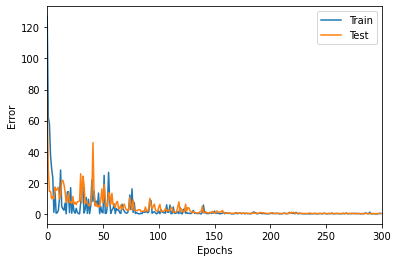

In [236]:
train_loss_list = torch.tensor(train_loss_list)
val_loss_list = torch.tensor(val_loss_list)

plt.xlim(0, epochs)
plt.plot(range(len(train_loss_list)), train_loss_list, label="Train")
plt.plot(range(len(val_loss_list)), val_loss_list, label="Test")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show()

In [256]:
# test_net = NET().to(torch.device("cpu"))
test_net = NET().to(device)
test_net.eval()
test_net.load_state_dict(torch.load('model' + str(best_epoch) + '.pth'))

<All keys matched successfully>

In [257]:
import seaborn
def test():
    test_net.eval()
    running_loss = 0
    with torch.no_grad():
        total_max_temp_error = 0
        total_min_temp_error = 0
        max_error_x = 0
        max_error_y = 0
        min_error_x = 0
        min_error_y = 0
        error_per_pix = 0
        loss_sum = 0
        max_error_x_abs = 0
        max_error_y_abs = 0
        min_error_x_abs = 0
        min_error_y_abs = 0
            
        estimate_list = []

        for batch_idx, (x, c) in enumerate(test_loader):
            x = x.to(device)
            c = c.to(device)
            estimate_start = time.time()
            y = test_net(x)
            estimate_end = time.time()
            estimate_duration = -estimate_start+estimate_end
            estimate_list.append(estimate_duration)
            loss = criterion(y, c)
            loss_unit = torch.sum(torch.abs(y-c))/16/18
            loss_sum = loss_sum + loss_unit
            running_loss += loss.item()
            
            
            y = y.cpu()
            c = c.cpu()
            c_reshaped = c.reshape(16, 18)
            seaborn.heatmap(c_reshaped, vmin=18, vmax=25)
            plt.show()
            y_reshaped = y.reshape(16, 18)
            seaborn.heatmap(y_reshaped, vmin=18, vmax=25)
            plt.show()
            print('==================')
            
            #最高温度のずれ
            max_temp_output = torch.max(c)
            max_temp_target = torch.max(y)
            max_temp_error = max_temp_output - max_temp_target
            total_max_temp_error = total_max_temp_error + max_temp_error

            #最低温度のずれ
            min_temp_output = torch.min(c)
            min_temp_target = torch.min(y)
            min_temp_error = min_temp_output - min_temp_target
            total_min_temp_error = total_min_temp_error + min_temp_error

            #最高温度を示すピクセルの座標のずれ(絶対値)
            max_temp_arg = torch.argmax(c)
            max_x_output = (max_temp_arg + 1)%18 -1
            max_y_output = -(max_temp_arg + 1)//18

            max_temp_arg = torch.argmax(y)
            max_x_target = (max_temp_arg + 1)%18 -1
            max_y_target = -(max_temp_arg + 1)//18
            
            max_error_x = max_error_x + abs(max_x_output - max_x_target)
            max_error_y = max_error_y + abs(max_y_output - max_y_target)

            # 最低温度を示すピクセルの座標のずれ(絶対値)
            min_temp_arg = torch.argmin(c)
            min_x_output = (min_temp_arg + 1)%18 -1
            min_y_output = -(min_temp_arg + 1)//18

            min_temp_arg = torch.argmin(y)
            min_x_target = (min_temp_arg + 1)%18 -1
            min_y_target = -(min_temp_arg + 1)//18
            
            min_error_x = min_error_x + abs(min_x_output - min_x_target)
            min_error_y = min_error_y + abs(min_y_output - min_y_target)

    print("推定平均時間:{}秒".format(sum(estimate_list)/len(estimate_list)))

    print('1ピクセルあたりの誤差', loss_sum/len(test_loader))
    print('最高温度のずれ', total_max_temp_error/len(test_loader))      
    print('最低温度のずれ', total_min_temp_error/len(test_loader))
    print('最高温度を示すピクセルの座標のずれ', max_error_x_abs/len(test_loader), max_error_y_abs/len(test_loader), )
    print('最低温度を示すピクセルの座標のずれ', min_error_x_abs/len(test_loader), min_error_y_abs/len(test_loader), )
    
    print("batch_size: {}　".format(batchsize))
    print(fpath)
    p = [loss_sum/len(test_loader), total_max_temp_error/len(test_loader), total_min_temp_error/len(test_loader), max_error_x/len(test_loader), max_error_y/len(test_loader), min_error_x/len(test_loader), min_error_y/len(test_loader), max_error_x_abs/len(test_loader), max_error_y_abs/len(test_loader), min_error_x_abs/len(test_loader), min_error_y_abs/len(test_loader), best_epoch]
    p = [float(x) for x in p]
    p.insert(0, histwindow)
    print(*p, sep=', ')

    val_loss = running_loss / len(test_loader)

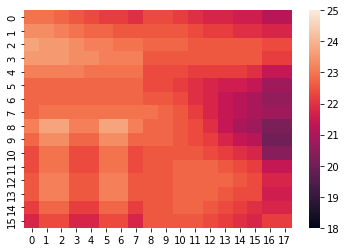

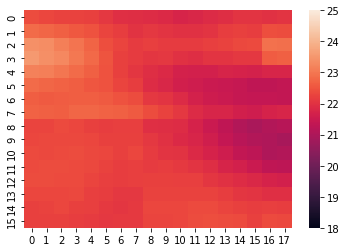

/tmp/ipykernel_2599640/895736095.py:60: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_y_output = -(max_temp_arg + 1)//18
/tmp/ipykernel_2599640/895736095.py:64: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_y_target = -(max_temp_arg + 1)//18
/tmp/ipykernel_2599640/895736095.py:72: UserWarning: __floordiv__ is deprecated, and i

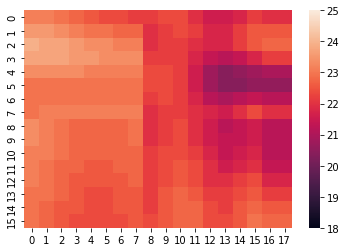

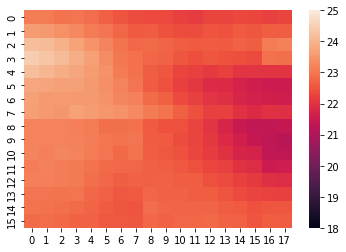

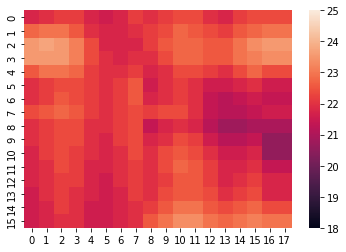

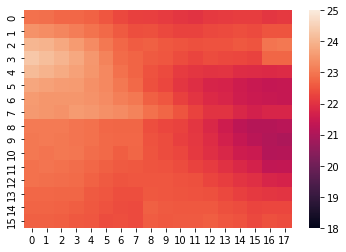

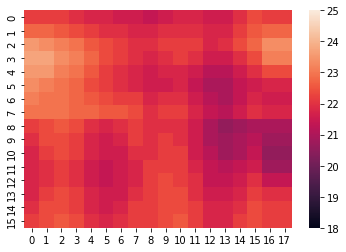

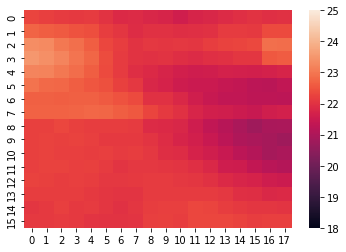

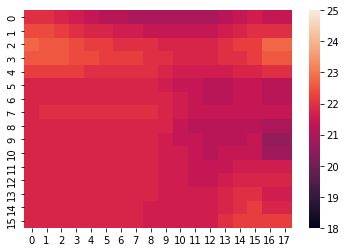

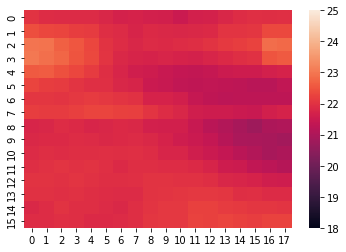

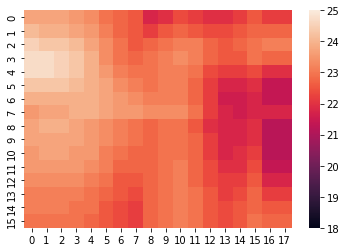

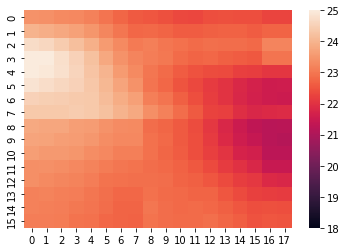

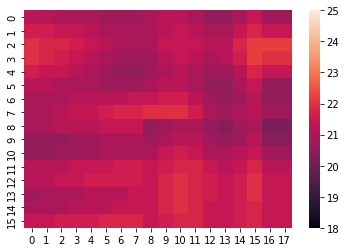

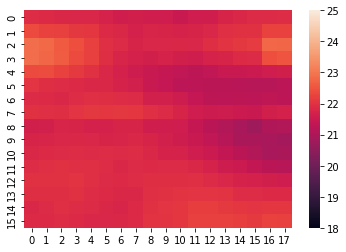

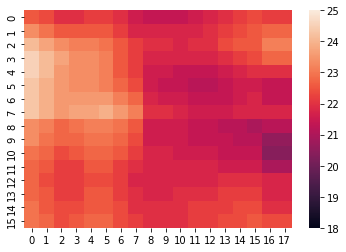

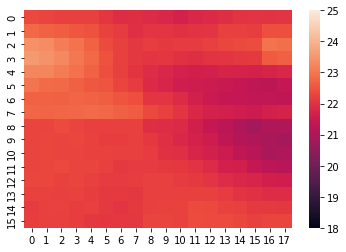

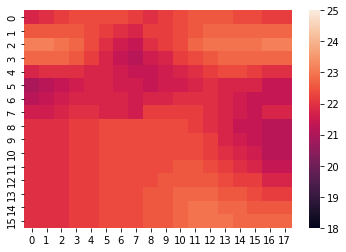

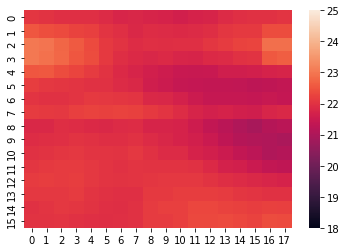

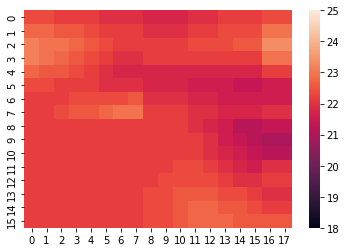

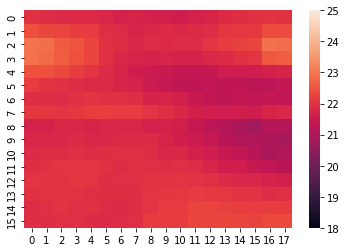

推定平均時間:0.0003407001495361328秒
1ピクセルあたりの誤差 tensor(0.3582, device='cuda:0')
最高温度のずれ tensor(-0.0615)
最低温度のずれ tensor(-0.3274)
最高温度を示すピクセルの座標のずれ 0.0 0.0
最低温度を示すピクセルの座標のずれ 0.0 0.0
batch_size: 200　
/proj/NARO/ghheatmap/orchid/refined_images_orchid
1, 0.35822978615760803, -0.06145191192626953, -0.3274053633213043, 3.200000047683716, 0.6000000238418579, 11.399999618530273, 1.7000000476837158, 0.0, 0.0, 0.0, 0.0, 296.0
5 : 8 : 9 : 16 : 18


In [258]:
test()
print(allsensors[0][6:] + ' : '  + allsensors[1][6:] + ' : ' + allsensors[2][6:] + ' : '  + allsensors[3][6:] + ' : ' + allsensors[4][6:])